# Projet d'optimisation : chauffage d'un bâtiment résidentiel
#### *Sebastian Partarrieu & Clement Desroches*

# 1. Modélisation


### Question 1

En premier lieu, on cherche à effectuer un modèle plausible compte tenu des données fournies.
Pour ce modèle, nous allons faire directement plusieurs hypothèses préliminaires: 
- le chauffage est exclusivement électrique, c'est justifié ces dernières années. 
- on suppose que l'énergie utilisée par la maison est exclusivement dûe au chauffage (c'est ce qu'on cherche à minimiser). Rajouter des sources de consommation d'énergies externes ne nous intéresse pas ici.

Ainsi la fonction à minimiser reste la facture d'électricité. On note $E_p$ ($E_c$) l'énergie consommée par la maison en heure pleine (creuse), $t_p$ ($t_c$) le tarif en heures pleines (creuses). On note M le montant à payer pour la consommation d'électricité.

Alors:
<center> $M = E_c * t_c + E_p * t_p \tag{1}$ </center>  

est la quantité que l'on sera amené à minimiser dans la deuxième partie de ce projet. Sa forme plus explicite ainsi que les contraintes associées seront détaillées une fois le modèle dynamique établi qui révelera les puissances mises en jeu à intégrer pour remonter aux énergies consommées.

### Question 2

Nous allons essayer de proposer un modèle de la température intérieure de la maison. Nous prenons donc comme système thermodynamique cet air à l'intérieur de la maison qui déterminera le confort des personnes à l'intérieur (en négligeant le fait que le confort thermique dépend de plusieurs facteurs, qui ne sont pas $T_{amb}$ la température ambiante de l'air, dont le métabolisme, les vêtements portés, l'humidité relative de l'air, la température des parois ou même la vitesse des mouvements d'air à l'intérieur de la maison).

>Venons en donc aux différentes sources de transferts thermiques qui sont :
>- le **chauffage intérieur** qui fournit une puissance $p_c(t)$
>- les **transferts thermiques à travers les murs** que l'on caractérise par un coefficient de perte $a$ qui sera déterminé par la suite.
>    Si l'on suppose que la maison est un cube de coté l, et les murs sont d'épaisseur $e_{mur}$ et le plafond $e_p$.
>    Pour un mur on obtient (On néglige la convection à l'intérieur de la maison) $R_{eq/mur} = \frac{1}{h*S_{mur}} + \frac{e_{mur}}{\lambda_{mur} * S_{mur}}$ avec $h$ le coefficient conducto-convectif qui caractérise les échanges de chaleur entre la paroi externe du mur et l'air.
>   
>    Donc pour 4 murs (en parallèle) : $ R_{eq/ 4murs} = \frac{R_{eq/mur}}{4}$    
>    
>    Pour le plafond : $R_{eq/p} = \frac{1}{h*S_{p}} + \frac{e_{p}}{\lambda_p * S_{p}}$ en considérant le même coefficient d'échange conducto-convectif que pour les murs (une hypothèse justifiée ci-dessous).
>    
 >   Donc pour la maison en entier : $R_{eq/ maison} = (\frac{1}{R_{eq/p}} + \frac{1}{R_{eq/4murs}})^{-1}$
 >   
 >   Alors on obtient finalement le coefficient de perte global de la maison qui caractérise les flux de chaleur à travers les parois: <center>$a = \frac{1}{R_{eq/maison}}, \Phi_{parois} = a*(T_{ext}(t)-T_{int}(t)) \tag{2}$</center>
 >   
>- **rayonnement thermique** : 
 >   $I_s(t) * S_{maison} * b$ (b étant un coefficient d'atténuation moyenné sur les quatres murs et le toit, $S_{maison}$ la surface extérieure de la maison et $I_s(t)$ le flux solaire moyenné sur les quatres murs et le toit) qui dépend de l'heure de la journée et donc du temps. 
    
Les hypothèses effectuées sont donc:
- La maison est cubique
- On néglige les mouvements d'air à l'intérieur de la maison.
- On considère un même coefficient conducto-convectif entre les murs et l'air et le plafond et l'air. Concrètement, comme la nature du fluide et la température est la même dans les deux cas, ceci revient à considérer qu'il y a le même type d'écoulement au dessus du plafond et au niveau des parois. 
- On néglige l'apport interne dû aux occupants, on considère donc une maison vide.
- On néglige la ventilation et les infiltrations d'air dans le bâtiment.
- On néglige les pertes par le sol, on fait l'hypothèse que le plancher est bien isolé et que la température du sol est proche de la température intérieure.
- Pour le rayonnement incident, en réalité il n'y que la surface *vitrée* sud qui laisse passer le rayonnement à l'intérieur, mais ici on fait une moyenne sur l'ensemble de la maison en considérant des parois semi-opaques caractérisées par ce coefficient d'atténuation
- En réalité, on a le flux solaire frappant une paroi qui se décompose en trois termes: le flux direct qui dépend de l'inclinaison et l'orientation des parois, le flux diffus (nuages), et le flux réfléchi par le sol et les autres parois. Ici on ne considère que le flux direct n'ayant pas accès aux conditions météo et ne pouvant pas décomposer le flux incident en cette somme de termes plus précis.
- Si on prend comme système l'air à l'intérieur de la maison, rayonnement thermique entre les parois et l'air comme pas forcément à la même température?

Finalement l'équation qui régit la dynamique de température de l'air à l'intérieur de la maison est: 
       <center> $C_{air}*\frac{\partial{T_{int}(t)}}{\partial{t}} = a*(T_{ext}(t)-T_{int}(t)) + p_c(t) + I_s(t) * S * b \tag{3} $ </center>
       où $C_{air}$ est la capacité thermique de l'air à l'intérieur de la maison.

### Question 3

Avant de discrétiser la dynamique et de proposer une méthodologie d'identification, on représente les données fournies pour appréhender correctement le problème. 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd

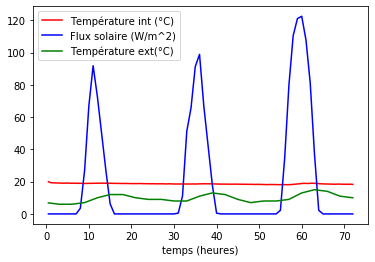

In [4]:
#visualisation des données
df = pd.read_csv('donnees-projet-gr4.txt', header = None,  delimiter='\t')
X, Y1, Y2, Y3 = np.array(df[0]), np.array(df[1]), np.array(df[2]), np.array(df[3])
plt.xlabel('temps (heures)')
plt.plot(X, Y1, c='r', label = 'Température int (°C)')
plt.plot(X, Y2, c='b', label = 'Flux solaire (W/m^2)')
plt.plot(X, Y3, c='g', label = 'Température ext(°C)')
plt.legend(loc='upper left')
plt.show()

On observe donc l'évolution de certains paramètres du problème sur une durée de trois jours. On voit directement que la température à l'intérieur de la maison reste constante au cours du temps, sans chauffage a priori ce qui nous amènera à éliminer le terme $p_c(t)$ dans l'équation (3). On sera amené à changer la température extérieure et le niveau de confort demandé à l'intérieur (température intérieure) plus tard dans le sujet.  


Pour l'instant, reprenons l'équation décrite précedemment sans terme de chauffage, 

$$C_{air}*\frac{\partial{T_{int}(t)}}{\partial{t}} = a*(T_{ext}(t)-T_{int}(t)) + I_s(t) * S_{maison} * b \tag{4}$$

On a $C_{air} = c_{air}V_{maison}$ avec $c_{air} = 1,256  kJ.m^{-3}.K^{-1}$ la capacité thermique volumique de l'air. D'après le modèle précédent, on a $V_{maison} = l^3$ avec $l$ le côté du carré qui modélise les murs et le plafond de la maison.

On connaît l'évolution de $T_{int}$, $T_{ext}$ et $I_s(t)$. Il s'agit donc d'estimer et identifier les paramètres $S_{maison} = l^2$, $a$, $b$ et $V_{maison} = l^3$. Finalement, il s'agit d'estimer ou d'identifier $l$, $a$ et $b$. 

#### Discrétisation de la dynamique

Reprenons (4), on discrétise donc les 72 heures en tranches d'une demi-heure, conformes aux données fournies sur Oasis. Nous avons donc $N = 144$ points et $\Delta t = 1/2 hr$. On ne considère plus $T_{int}$, $T_{ext}$ et $I_{s}$ comme des fonctions continues du temps, ce qui donne:
<center> $C_{air}*(T_{int}^{i+1} - T_{int}^{i}) = \Delta t * a *(T_{ext}^{i}-T_{int}^{i}) + I_s^{i} * S_{maison} * b \tag{5}$ </center>

Si l'on considère que $T_{int}^{i+1} - T_{int}^{i}$ est une constante, qui se justifie par le fait que la variation caractéristique de la température à l'intérieur est beaucoup plus faible (de l'ordre de 0,1°C) que les termes à droite de l'équation (5).

-0.011526137131788095


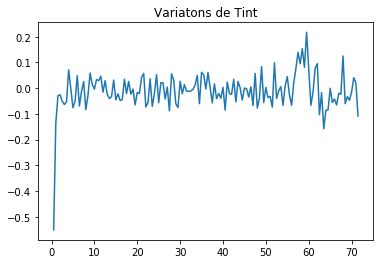

In [5]:
#illustration des variations de la température intérieur.
Y_reg = Y1[1:] - Y1[:-1]
X_reg = X[:-1]
plt.plot(X_reg, Y_reg)
plt.title("Variatons de Tint")
constante = Y_reg.mean() #la constante est prise comme la moyenne de ces variations
print(constante)

On se ramène donc à l'équation:  $$C_{air}*C_{ste} = \Delta t * a *(T_{ext}^{i}-T_{int}^{i}) + I_s^{i} * S_{maison} * b$$

Qu'on transforme aussitôt en:
$$ T_{ext}^{i}-T_{int}^{i} = \frac{l^3 c_{air}}{\Delta t a}*C_{ste} +  \frac{-b l^{2}}{\Delta t a}*I_s^{i}  \tag{6} $$

et on effectue une regréssion linéaire $ Y = \alpha X + \beta$ avec $Y = T_{ext}^{i}-T_{int}^{i}$, $\alpha = \frac{-b l^{2}}{\Delta t a}$, $\beta = \frac{l^3 c_{air}}{\Delta t a}*C_{ste}$ et $X = I_s^{i}$

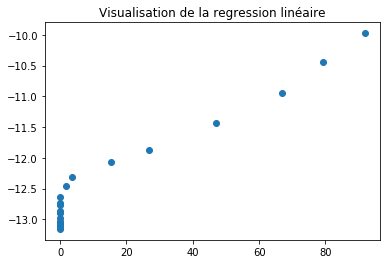

In [6]:
#visualisation de notre regression linéaire sur une tranche adéquate,
Y_reg_2 = Y3 - Y1
Y_reg_2 = Y_reg_2[:22]
X_reg_2 = Y2[:22]
plt.scatter(X_reg_2, Y_reg_2)
plt.title("Visualisation de la regression linéaire")
plt.show()

In [7]:
#Regression linéaire
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(X_reg_2, Y_reg_2 )
print(f'alpha = {slope}, coefficient de corrélation = {r_value}, beta = {intercept}')

alpha = 0.03145293507978379, coefficient de corrélation = 0.9722905331900278, beta = -12.88897734749295


Le coefficient de corrélation trouvé confirme ainsi la validité de notre hypothèse et la regression linéaire effectuée. On en déduit deux relations, à travers $\alpha$ et $\beta$ qui relient les trois paramètres $l$, $a$ et $b$. Il nous manque donc une relation pour pouvoir déduire les trois paramètres de nos donneés.

> On a effectivement une relation entre a et l (à travers la surface des murs et du plafond) le problème c'est que ça fait intervenir deux nouvelles constantes que l'on ne connaît pas a priori, $e_{mur}$ et les conductivités thermiques.
>
> Du coup on cherche plutôt à relier b et l. Comment? je ne sais pas
>
> Dernière option: estimer "à la mano" un des paramètres pour en déduire les deux derniers. Sinon on peut toujours tracer l'évolution de alpha et beta en fonction de l et choisir un l qui a du sens du point de vue physique pour une maison et qui donne aussi des coef d'atténuation et une résistance thermique qui tienent debouts. 


### Question 4

Notre but est de minimiser la puissance du chauffage, 
 <center> $ p_c(t, a, b, l) = C_{air}*\frac{\partial{T_{int}(t)}}{\partial{t}}  - I_s(t) * S * b - a*(T_{ext}(t)-T_{int}(t))  $ </center>

D'après EDF les heures creuses sont limitées à 8h maximum par jour, nous choisissons une plage d'heures creuses de 00h00 à 8h du matin.
 
Donc $E_c = \int_{0}^{8h}p_c(t)dt$ et de même $E_p = \int_{8h}^{24h}p_c(t)dt$

Les varia

Les contraintes sont au nombre de 5 :
- La température intérieure doit rester entre 19°C et 22°C.
- La variation de la température doit être limitée également à moins de 0.5°C par heure donc $\left \|\frac{\partial{T_{int}(t)}}{\partial{t}}\right \| < 0.5 $
- La contrainte sur la géométrie de la maison qui doit être réaliste (l compris entre 10m et 20m, cela correspondrait à une maison entre 100m2 (petite maison) et 400m2 (grande maison)). 
- La contrainte métérologique b doit être compris entre 0 et 1 car c'est un coefficient d'atténuation.
- Les contraintes chimiques sur $\lambda$ et $h$ qui sont contraints par les matériaux utilisés pour isoler le mur. Cela entraine des contraintes sur a.